In [16]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [17]:
def plot_dynamic_timelock(timestep_data_df):
    import matplotlib.pyplot as plt
    from matplotlib import ticker as mtick
    import numpy as np

    days = timestep_data_df['timestep'] * 3 / 24
    escrow = timestep_data_df['actors_total_locked_relative']
    dynamic_timelock_days = timestep_data_df['dg_dynamic_timelock_seconds'] / 3600 / 24

    ragequit_day = timestep_data_df[timestep_data_df['dg_state_name'] == 'RageQuit'].timestep.min() * 3 / 24

    start = timestep_data_df['timestep'][timestep_data_df['dg_state_name'] == 'VetoSignalling'].min() - 1
    first_point = start + 5 * 24 / 3, 0.01
    second_point = first_point[0] + 45 * 24 / 3, 0.1
    n_timesteps = second_point[0] - first_point[0]
    d_share = (second_point[1] - first_point[1]) / n_timesteps
    looked_timesteps = np.arange(first_point[0], second_point[0]).astype(np.int32)
    needed_shares = 0.01 + (looked_timesteps - first_point[0]) * d_share

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(looked_timesteps * 3 / 24, needed_shares, label='Dynamic timelock', color='red')
    ax.plot(timestep_data_df['timestep'] * 3 / 24, escrow, label='Escrow balance (%)', color='green')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_ylabel('Tokens in Escrow')
    ax.set_xlabel('Days')

    xlim = ax.get_xlim()
    ax.plot(xlim, [0.1, 0.1], color='gray', linestyle='--')
    ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--')
    ax.set_xlim(xlim)

    ylim = ax.get_ylim()
    ax.plot([ragequit_day, ragequit_day], ylim, color='gray', linestyle='--')
    ax.set_ylim(ylim)

    # Find all timesteps where the current state is VetoSignallingDeactivation and the previous state was VetoSignalling
    veto_deactivation_timesteps = timestep_data_df[
        (timestep_data_df['dg_state_name'] == 'VetoSignallingDeactivation') &
        (timestep_data_df['dg_state_name'].shift(1) == 'VetoSignalling')
    ]['timestep'] * 3 / 24

    for out_of_veto in veto_deactivation_timesteps:
        ax.plot([out_of_veto, out_of_veto], ylim, color='orange', linestyle='--')

    ax.set_ylim(ylim)

    ax2 = ax.twinx()
    ax2.plot(days, timestep_data_df['dg_state_name'], label='DGState')
    
    ax.legend(*[sum(x, []) for x in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())])

    return fig

In [20]:
# Read the data
# path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_modified_slow_delay/")
# path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_delay_sweep/")
path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement/")
# path_to_runs = Path("../../results/simulations/withdrawal_queue_replacement_different_slow_reaction_limit/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve())
print(len(start_data_df_full))


/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/withdrawal_queue_replacement
True
1400


In [23]:
from experiments.analysis_utils.metrics import analyze_ragequit_timing_by_seals

start_data_df_full['slow_actor_max_delay_days'] = start_data_df_full['slow_actor_max_delay'] / 60 / 60 / 24
ragequit_stats = analyze_ragequit_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('slow_actor_max_delay_days',))
print("Ragequit statistics by seal parameters:")

display(ragequit_stats.reorder_levels(['first_seal_rage_quit_support', 'slow_actor_max_delay_days', 'second_seal_rage_quit_support']).sort_index()
)

Ragequit statistics by seal parameters:


ragequit_rate  \
first_seal_rage_quit_support slow_actor_max_delay_days second_seal_rage_quit_support                  
0.01                         15.0                      0.10                                   100.0   
                                                       0.12                                   100.0   
                                                       0.15                                   100.0   
                             30.0                      0.10                                    96.0   
                                                       0.12                                    69.0   
                                                       0.15                                    16.0   
                             35.0                      0.12                                    69.0   
                                                       0.15                                    16.0   
                             40.0                      0.12                                     1.0   
                                                       0.15                                     0.0   
                             45.0                      0.10                                     1.0   
                                                       0.12                                     1.0   
                                                       0.15                                     0.0   
                             60.0                      0.10                                     0.0   

                                                                                      mean_time_to_ragequit  \
first_seal_rage_quit_support slow_actor_max_delay_days second_seal_rage_quit_support                          
0.01                         15.0                      0.10                                           363.0   
                                                       0.12                                           363.0   
                                                       0.15                                           363.0   
                             30.0                      0.10                                           363.0   
                                                       0.12                                           363.0   
                                                       0.15                                           363.0   
                             35.0                      0.12                                           363.0   
                                                       0.15                                           363.0   
                             40.0                      0.12                                           363.0   
                                                       0.15                                             NaN   
                             45.0                      0.10                                           363.0   
                                                       0.12                                           363.0   
                                                       0.15                                             NaN   
                             60.0                      0.10                                             NaN   

                                                                                      median_time_to_ragequit  \
first_seal_rage_quit_support slow_actor_max_delay_days second_seal_rage_quit_support                            
0.01                         15.0                      0.10                                             363.0   
                                                       0.12                                             363.0   
                                                       0.15                                             363.0   
                             30.0                      0.10                                    

In [32]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')
failed_runs = timestep_data_df_full_with_params.groupby('run_id').agg({'dg_state_name': lambda x: 'RageQuit' not in x.values})
failed_runs = timestep_data_df_full_with_params.groupby('run_id').agg({'dg_state_name': lambda x: 'RageQuit' not in x.values})
failed_run_ids = failed_runs[failed_runs['dg_state_name']].reset_index().run_id
mask = (timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 30) & (timestep_data_df_full_with_params['second_seal_rage_quit_support'] == 0.1) & (timestep_data_df_full_with_params['run_id'].isin(failed_run_ids))
needed_run_ids = timestep_data_df_full_with_params[mask].run_id.unique()

In [48]:
start = timestep_data_df_full_with_params[(timestep_data_df_full_with_params['run_id'] == needed_run_ids[0]) & (timestep_data_df_full_with_params['timestep'] == 1)]
start.balance_Slow / start.actors_total_balance

504000    0.341803
dtype: float64

(0.0, 200.0)

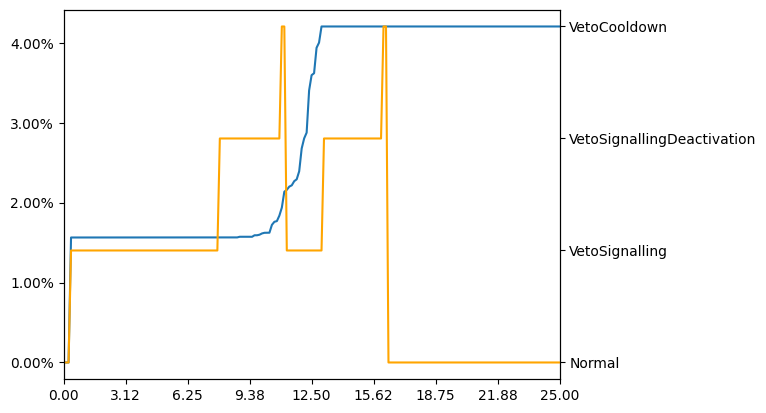

In [41]:
run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == needed_run_ids[0]]
plt.plot(run['timestep'], run['actors_total_locked_relative'])
from matplotlib.ticker import FuncFormatter, PercentFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 3 / 24:.2f}'))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax2 = plt.twinx()

ax2.plot(run['timestep'], run['dg_state_name'], color='orange')
plt.xlim(0, 200)


(0.0, 200.0)

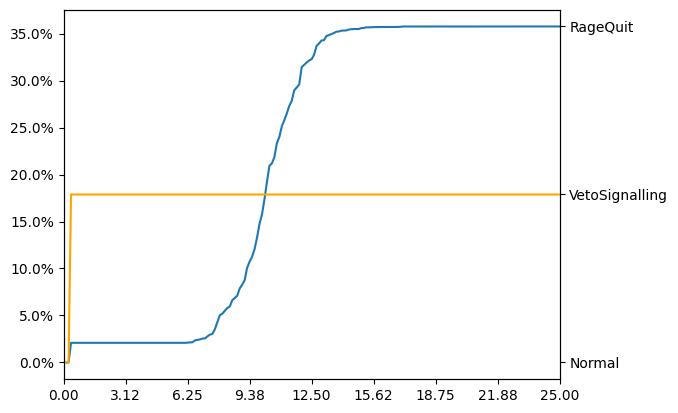

In [49]:
run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == needed_run_ids[0] - 1]
plt.plot(run['timestep'], run['actors_total_locked_relative'])
from matplotlib.ticker import FuncFormatter, PercentFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 3 / 24:.2f}'))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax2 = plt.twinx()

ax2.plot(run['timestep'], run['dg_state_name'], color='orange')
plt.xlim(0, 200)


In [6]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')

# Group the data and extract deactivation stats directly into a DataFrame
deactivation_stats = (
    timestep_data_df_full_with_params
    .groupby('run_id')
    .agg(
        had_deactivation=('dg_state_name', lambda x: ('VetoSignallingDeactivation' in x.values) and ('RageQuit' in x.values)),
        first_seal_rage_quit_support=('first_seal_rage_quit_support', 'first'),
        second_seal_rage_quit_support=('second_seal_rage_quit_support', 'first'),
        slow_actor_max_delay_days=('slow_actor_max_delay_days', 'first')
    )
    .reset_index()
)

# Convert the results to a DataFrame
deactivation_stats.groupby(['first_seal_rage_quit_support', 'second_seal_rage_quit_support', 'slow_actor_max_delay_days']).agg({'had_deactivation': ['mean', 'sum']})

had_deactivation  \
                                                                                                 mean   
first_seal_rage_quit_support second_seal_rage_quit_support slow_actor_max_delay_days                    
0.01                         0.1                           15.0                              0.000000   
                                                           30.0                              0.000000   
                                                           35.0                              0.060000   
                                                           40.0                              0.543333   
                                                           45.0                              0.420000   
                                                           50.0                              0.130000   
                                                           55.0                              0.010000   
                                                           60.0                              0.000000   

                                                                                           
                                                                                      sum  
first_seal_rage_quit_support second_seal_rage_quit_support slow_actor_max_delay_days       
0.01                         0.1                           15.0                         0  
                                                           30.0                         0  
                                                           35.0                        18  
                                                           40.0                       163  
                                                           45.0                        84  
                                                           50.0                        39  
                                                           55.0                         3  
                                                           60.0                         0

In [7]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')
threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')
threshold_times['threshold_hours'] = threshold_times['threshold_timestep'] * 3
threshold_times = threshold_times.merge(start_data_df_full, on='run_id', how='left')
threshold_times['slow_actor_max_delay_days'] = threshold_times['slow_actor_max_delay'] / 24 / 60 / 60
threshold_times.groupby(['second_seal_rage_quit_support', 'slow_actor_max_delay_days']).agg({'threshold_hours': ['median', 'mean', 'std', 'min', 'max'], 'run_id': 'count'})


/tmp/ipykernel_10751/3130549630.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')


threshold_hours  \
                                                                 median   
second_seal_rage_quit_support slow_actor_max_delay_days                   
0.1                           15.0                                219.0   
                              30.0                                366.0   
                              35.0                                414.0   
                              40.0                                462.0   
                              45.0                                507.0   
                              50.0                                555.0   
                              55.0                                600.0   
                              60.0                                657.0   

                                                                     \
                                                               mean   
second_seal_rage_quit_support slow_actor_max_delay_days               
0.1                           15.0                       219.660000   
                              30.0                       364.230000   
                              35.0                       412.300000   
                              40.0                       460.525773   
                              45.0                       507.461538   
                              50.0                       555.437500   
                              55.0                       604.065789   
                              60.0                       655.787234   

                                                                           \
                                                               std    min   
second_seal_rage_quit_support slow_actor_max_delay_days                     
0.1                           15.0                        4.401279  204.0   
                              30.0                        9.463875  330.0   
                              35.0                       11.291368  375.0   
                              40.0                       12.838057  417.0   
                              45.0                       14.282578  459.0   
                              50.0                       15.904195  501.0   
                              55.0                       16.560463  567.0   
                              60.0                       17.035687  618.0   

                                                               run_id  
                                                           max  count  
second_seal_rage_quit_support slow_actor_max_delay_days                
0.1                           15.0                       231.0    200  
                              30.0                       393.0    200  
                              35.0                       447.0    300  
                              40.0                       492.0    300  
                              45.0                       537.0    200  
                              50.0                       585.0    300  
                              55.0                       636.0    300  
                              60.0                       687.0    200

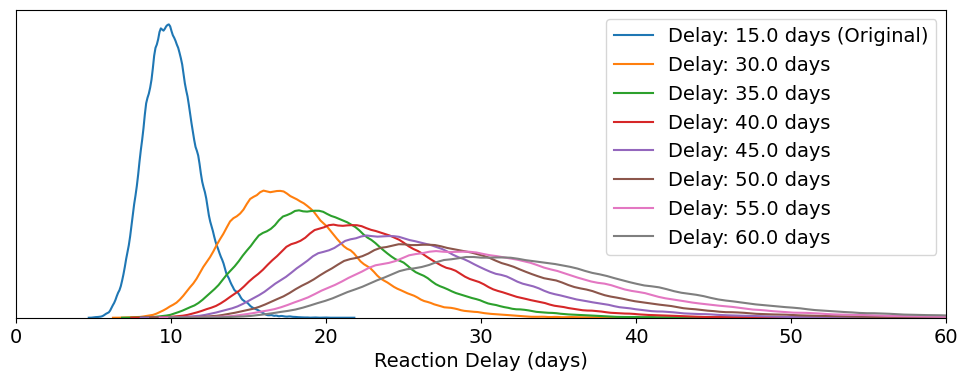

In [15]:
from model.utils.reactions import ReactionDelayGenerator
from model.types.reaction_time import ReactionTime
from model.utils.seed import initialize_seed
from model.sys_params import CustomDelays

reaction_time = np.zeros(100000)
reaction_time[:] = ReactionTime.Slow.value

import seaborn as sns
fig_height = 4
fig_aspect = 3
plt.figure(figsize=(fig_height * fig_aspect, fig_height))
for slow_actor_max_delay_days in sorted(threshold_times.slow_actor_max_delay_days.unique()):
    initialize_seed(1)
    generator = ReactionDelayGenerator(CustomDelays(slow_max_delay=slow_actor_max_delay_days * 24 * 60 * 60))
    reactions = generator.generate_reaction_delay_vector(reaction_time)
    reactions = np.divide(reactions, 24 * 60 * 60)
    label = f'Delay: {slow_actor_max_delay_days} days'
    if slow_actor_max_delay_days == 15:
        label += ' (Original)'
    sns.kdeplot(reactions, label=label, bw_adjust=0.5)  # Adjust bw_adjust for smoother or rougher plots

label_size = 16
tick_size = 14
title_size = 18

plt.xlim(0, 60)
plt.legend(fontsize=tick_size)
plt.xlabel('Reaction Delay (days)', fontsize=tick_size)
plt.ylabel('')
plt.gca().yaxis.set_ticklabels([])
plt.gca().yaxis.set_ticks([]);
plt.gca().xaxis.set_tick_params(labelbottom=True, labelsize=tick_size)
plt.savefig('../../images/slow_sweep_reaction_delay_distribution.svg', transparent=True)

In [8]:
np.unique(reactions)

array([ 11.23501157,  11.44287037,  11.46643519, ...,  92.90940972,
        97.37333333, 103.80623843])

Text(0.5, 0.98, 'Unsuccessful RageQuit')

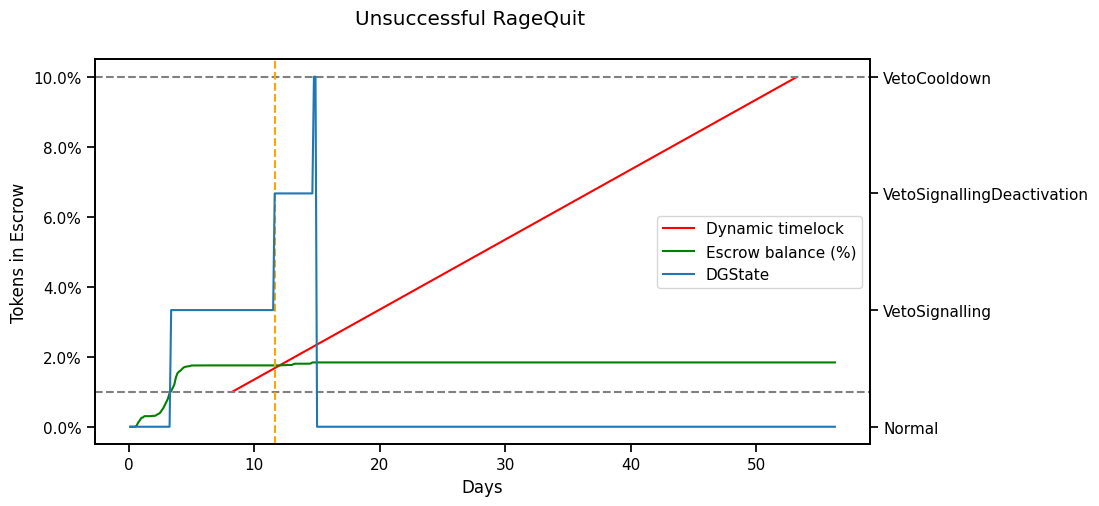

In [24]:
sns.set_context('notebook')
run_id = 1999
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]
fig = plot_dynamic_timelock(timestep_data_df)
fig.suptitle('Unsuccessful RageQuit')

Text(0.5, 0.98, 'Successful RageQuit')

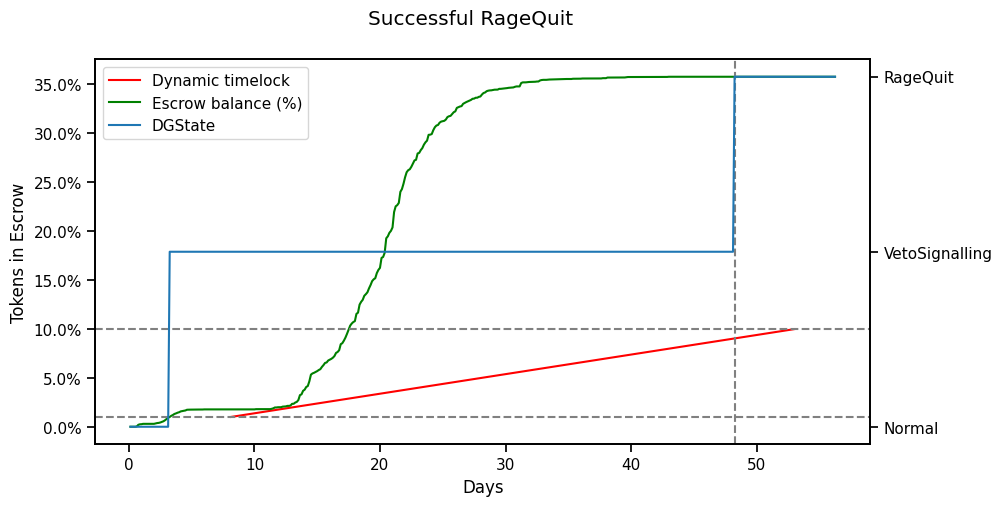

In [26]:
sns.set_context('notebook')
run_id = 6
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]
fig = plot_dynamic_timelock(timestep_data_df)
fig.suptitle('Successful RageQuit')

## Below are failed attempts to visualize the relationship between escrow and dynamic timelock

In [199]:
tr1 = 0.01
tr2 = 0.1

t_max = 45 # days
t_min = 5 # days

t_min_timesteps = t_min * 24 / 3

dt_by_des = (t_max - t_min) / (tr2 - tr1) # days per full share

dt_by_des_timesteps = dt_by_des * 24 / 3 # timesteps (timestep = 3 hours, day = 24 hours = 24 / 3 timesteps, timestep = 3 / 24 days)

def get_dynamic_timesteps(share):
    return (np.minimum(tr2, share) - tr1) * (t_max - t_min) * (24 / 3) / (tr2 - tr1)

Text(0, 0.5, 'Timesteps allowed')

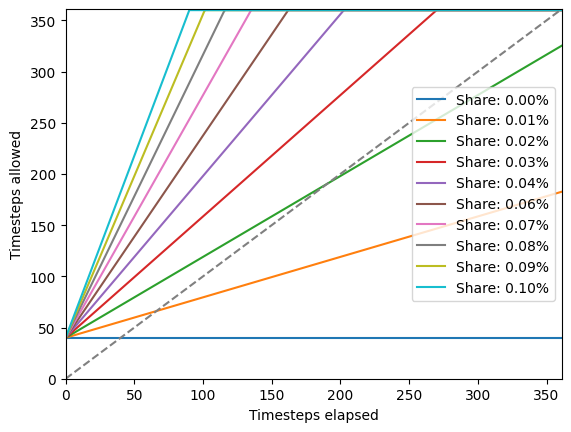

In [221]:
timesteps = np.arange(400)

for share in np.linspace(0, 0.001, 10):
    plt.plot(timesteps, t_min_timesteps + get_dynamic_timesteps(0.01 + share * timesteps), label=f'Share: {share * 100:.2f}%')

plt.plot(timesteps, timesteps, color='gray', linestyle='--')
plt.legend()


plt.ylim(0, t_max * 24 / 3 + 1)
plt.xlim(0, t_max * 24 / 3 + 1)
plt.xlabel('Timesteps elapsed')
plt.ylabel('Timesteps allowed')


In [227]:
max_share = 0.03 / 100

minimal_share = 10000
for share in np.linspace(0, max_share, 1000000)[1:][::-1]:
    timesteps_needed = 0.09 / share
    timesteps = np.arange(timesteps_needed + 1)
    timesteps_allowed = t_min_timesteps + get_dynamic_timesteps(0.01 + share * timesteps)
    if (timesteps_allowed > timesteps).all():
        minimal_share = share
    else:
        break

timesteps_needed = 0.09 / minimal_share
print(minimal_share, timesteps_needed)


0.0002506964506964507 358.9998970865932


False


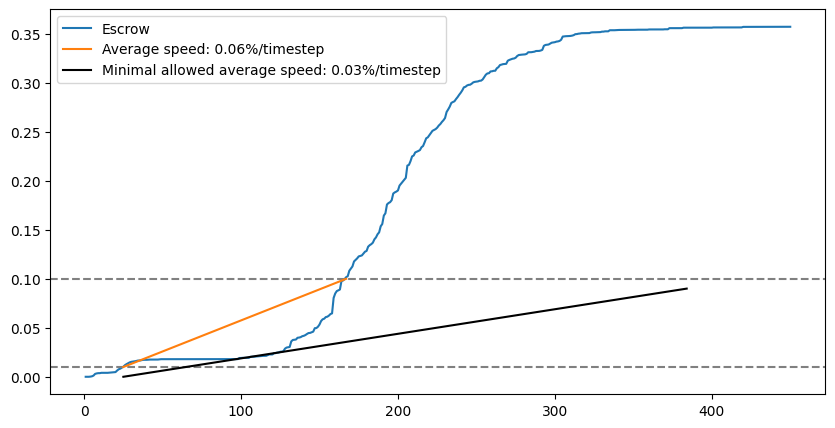

In [280]:
bad_run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 45].iloc[2].run_id
good_run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 30].iloc[0].run_id

from matplotlib import ticker as mtick

run_id = bad_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]

print((timestep_data_df.dg_state_name == 'RageQuit').any())

start_timestep = timestep_data_df['timestep'][timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
end_timestep = timestep_data_df['timestep'][timestep_data_df['actors_total_locked_relative'] >= tr2].min()


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(timestep_data_df['timestep'], timestep_data_df['actors_total_locked_relative'], label='Escrow')

xlim = ax.get_xlim()
ax.plot(xlim, [tr2, tr2], color='gray', linestyle='--')
ax.plot(xlim, [tr1, tr1], color='gray', linestyle='--')
ax.set_xlim(xlim)

average_speed = (tr2 - tr1) / (end_timestep - start_timestep)
ax.plot([start_timestep, end_timestep], [tr1, tr2], label=f'Average speed: {average_speed*100:.2f}%/timestep')
ax.plot([start_timestep, start_timestep + (tr2-tr1) / minimal_share], [0, tr2-tr1], label=f'Minimal allowed average speed: {minimal_share*100:.2f}%/timestep', color='black')

ax.legend()



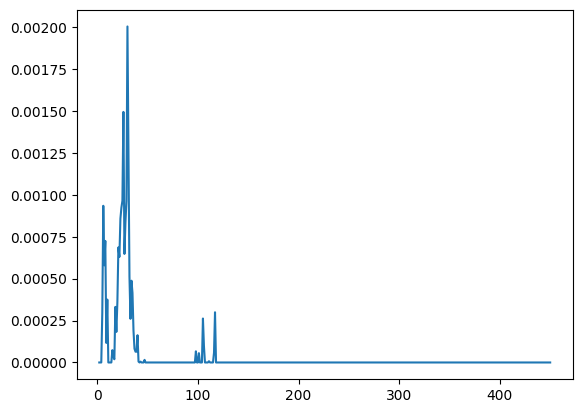

In [293]:
plt.plot(timestep_data_df['timestep'], timestep_data_df['actors_total_locked_relative'].diff())

True


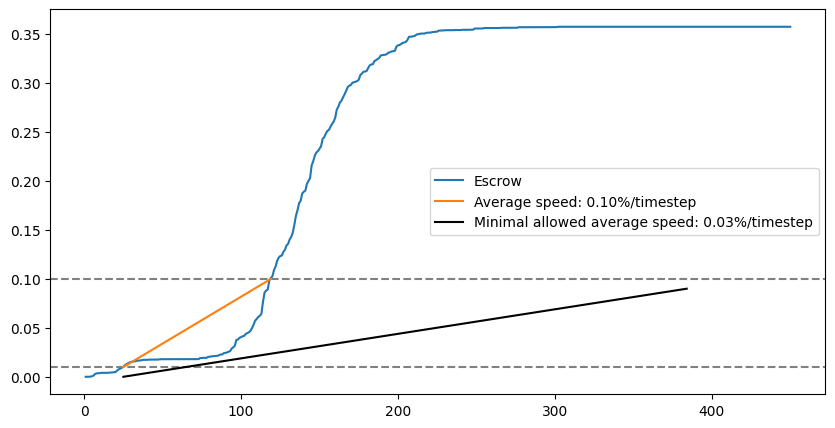

In [245]:
bad_run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 45].iloc[2].run_id
good_run = timestep_data_df_full_with_params[timestep_data_df_full_with_params['slow_actor_max_delay_days'] == 30].iloc[0].run_id

from matplotlib import ticker as mtick

run_id = good_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]

print((timestep_data_df.dg_state_name == 'RageQuit').any())

start_timestep = timestep_data_df['timestep'][timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
end_timestep = timestep_data_df['timestep'][timestep_data_df['actors_total_locked_relative'] >= tr2].min()


fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(timestep_data_df['timestep'], timestep_data_df['actors_total_locked_relative'], label='Escrow')

xlim = ax.get_xlim()
ax.plot(xlim, [tr2, tr2], color='gray', linestyle='--')
ax.plot(xlim, [tr1, tr1], color='gray', linestyle='--')
ax.set_xlim(xlim)

average_speed = (tr2 - tr1) / (end_timestep - start_timestep)
ax.plot([start_timestep, end_timestep], [tr1, tr2], label=f'Average speed: {average_speed*100:.2f}%/timestep')
ax.plot([start_timestep, start_timestep + (tr2-tr1) / minimal_share], [0, tr2-tr1], label=f'Minimal allowed average speed: {minimal_share*100:.2f}%/timestep', color='black')

ax.legend()



In [288]:
speed_list = []
min_speed_list = []
max_speed_list = []
acceleration_list = []
nan_list = []
success_list = []
linetest_list = []
min_weighted_speed_list = []
max_weighted_speed_list = []

for run_id in timestep_data_df_full_with_params['run_id'].unique():
    timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]
    start_timestep = timestep_data_df['timestep'][timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
    start_value = timestep_data_df['actors_total_locked_relative'][timestep_data_df['timestep'] == start_timestep].min()
    end_timestep = timestep_data_df['timestep'][timestep_data_df['actors_total_locked_relative'] >= tr2].min()
    if np.isnan(end_timestep):
        nan_list.append(True)
    else:
        nan_list.append(False)
    average_speed = (tr2 - start_value) / (end_timestep - start_timestep)
    escrow = timestep_data_df['actors_total_locked_relative'][(timestep_data_df['timestep'] >= start_timestep) & (timestep_data_df['timestep'] <= end_timestep)]
    speed = escrow.diff()
    min_speed = speed.min()
    max_speed = speed.max()
    weighted_speed = escrow.rolling(window=50).mean().diff()
    min_weighted_speed = weighted_speed.min()
    max_weighted_speed = weighted_speed.max()
    min_speed_list.append(min_speed)
    max_speed_list.append(max_speed)
    min_weighted_speed_list.append(min_weighted_speed)
    max_weighted_speed_list.append(max_weighted_speed)
    average_acceleration = average_speed / (end_timestep - start_timestep)
    
    success = (timestep_data_df.dg_state_name == 'RageQuit').any()
    success_list.append(success)
    speed_list.append(average_speed)

    max_possible_timestep = start_timestep + (tr2-tr1) / minimal_share if np.isnan(end_timestep) else end_timestep
    test_timesteps = np.arange(start_timestep, max_possible_timestep)
    test_shares = minimal_share * test_timesteps
    tested_shares = timestep_data_df['actors_total_locked_relative'][timestep_data_df['timestep'].isin(test_timesteps)]
    test_failed = (tested_shares < test_shares).any()
    linetest_list.append(test_failed)
df = pd.DataFrame({'speed': speed_list, 'success': success_list, 'linetest': linetest_list, 'nan': nan_list, 'min_speed': min_speed_list, 'max_speed': max_speed_list, 'min_weighted_speed': min_weighted_speed_list, 'max_weighted_speed': max_weighted_speed_list})


In [334]:
linetest_list = []
success_list = []
run_ids = []

for run_id in timestep_data_df_full_with_params['run_id'].unique():
    timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]
    start = timestep_data_df['timestep'][timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
    first_point = start + 5 * 24 / 3, 0.01
    second_point = first_point[0] + 45 * 24 / 3, 0.1
    n_timesteps = second_point[0] - first_point[0]
    d_share = (second_point[1] - first_point[1]) / n_timesteps
    looked_timesteps = np.arange(first_point[0], second_point[0])
    needed_shares = 0.01 + (looked_timesteps - first_point[0]) * d_share

    actual_shares = timestep_data_df['actors_total_locked_relative'][timestep_data_df['timestep'].isin(looked_timesteps)]
    linetest_list.append((actual_shares > needed_shares).all())
    success_list.append((timestep_data_df['dg_state_name'] == 'RageQuit').any())

    run_ids.append(run_id)

df = pd.DataFrame({'success': success_list, 'linetest': linetest_list, 'run_id': run_ids})

In [339]:
df[df.success != df.linetest]

,success,linetest,run_id
5,True,False,5
8,True,False,8
12,True,False,12
13,True,False,13
18,True,False,18
...,...,...,...
1968,True,False,1968
1972,True,False,1972
1973,True,False,1973
1988,True,False,1988


(-0.5, 1.5)

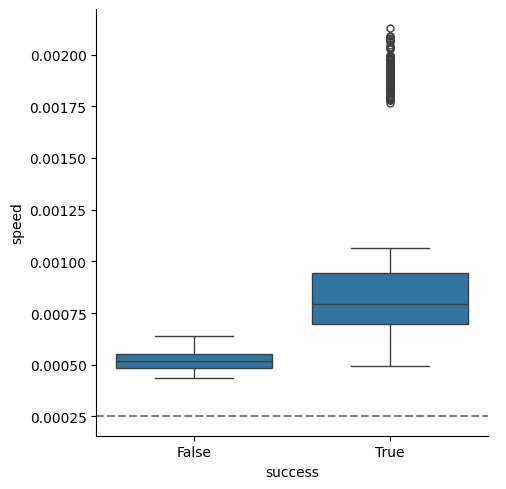

In [289]:
import seaborn as sns
sns.catplot(data=df, x='success', y='speed', kind='box')
xlim = plt.xlim()
plt.plot(xlim, [minimal_share, minimal_share], color='gray', linestyle='--')
plt.xlim(xlim)

(-0.5, 1.5)

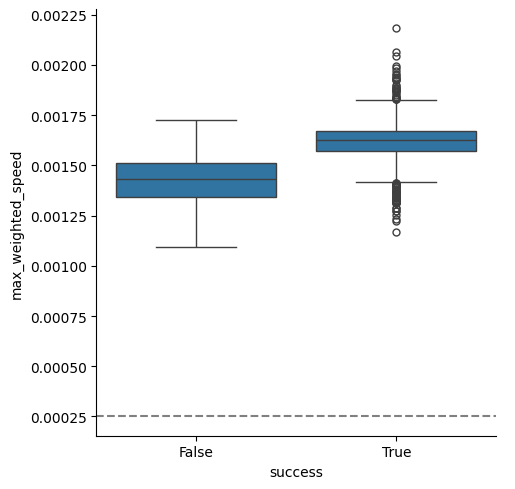

In [291]:
import seaborn as sns
sns.catplot(data=df, x='success', y='max_weighted_speed', kind='box')
xlim = plt.xlim()
plt.plot(xlim, [minimal_share, minimal_share], color='gray', linestyle='--')
plt.xlim(xlim)

In [258]:
good_failed_speeds = np.array(good_failed_speeds)
print(good_failed_speeds.mean(), good_failed_speeds.min(), good_failed_speeds.max())


0.0005233494726127054 0.00044117647058823536 0.0006428571428571429


nan


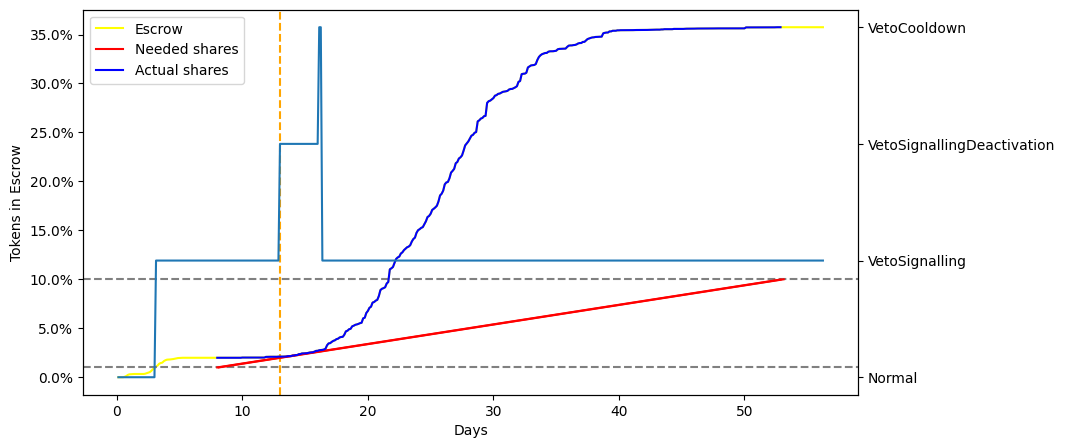

In [383]:
timestep_data_df['slow_actor_max_delay_days']

247500    45.0
247501    45.0
247502    45.0
247503    45.0
247504    45.0
          ... 
247945    45.0
247946    45.0
247947    45.0
247948    45.0
247949    45.0
Name: slow_actor_max_delay_days, Length: 450, dtype: float64

In [378]:
needed_shares[(looked_timesteps * 3 / 24 >= 13.5) & (looked_timesteps * 3 / 24 <= 14.5)]


array([0.021  , 0.02125, 0.0215 , 0.02175, 0.022  , 0.02225, 0.0225 ,
       0.02275, 0.023  ])

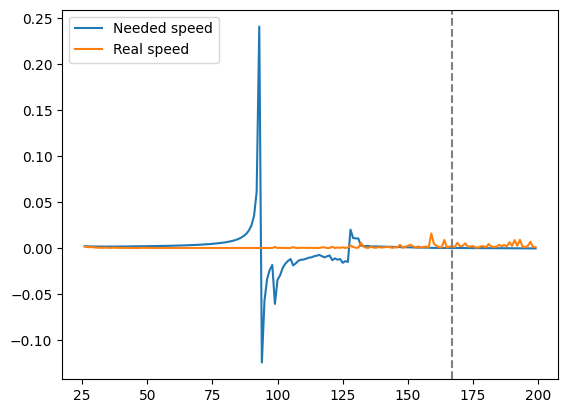

In [108]:
threshold = 0.1
run_id = bad_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]

escrow = timestep_data_df['actors_total_locked_relative']
hours = timestep_data_df['timestep'] * 3
start_hours = hours[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
dynamic_timelock_hours = timestep_data_df['dg_dynamic_timelock_seconds'] / 3600
needed_speed = (threshold - escrow) / (dynamic_timelock_hours - start_hours)
real_speed = escrow.diff() / 3

dynamic_timelock_seconds = timestep_data_df['dg_dynamic_timelock_seconds']

timesteps = timestep_data_df['timestep']
seconds = timesteps * 3 * 60 * 60
start_timestep = timesteps[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
start_seconds = start_timestep * 3 * 60 * 60
elapsed_from_start_timesteps = timesteps - start_timestep
elapsed_from_start_seconds = elapsed_from_start_timesteps * 3 * 60 * 60
seconds_left_to_reach_ragequit = dynamic_timelock_seconds - elapsed_from_start_seconds
timesteps_left_to_reach_ragequit = seconds_left_to_reach_ragequit / 3 / 60 / 60
share_left_to_reach_ragequit = threshold - escrow
needed_speed_seconds = share_left_to_reach_ragequit / seconds_left_to_reach_ragequit
needed_speed_timesteps = needed_speed_seconds * 3 * 60 * 60

delta_share = escrow.diff()
delta_timesteps = timesteps.diff()
real_speed_timesteps = delta_share / delta_timesteps


timestep_threshold = timesteps[escrow >= threshold].min()


mask = (timesteps > start_timestep) & (timesteps < 200)
plt.plot(timesteps[mask], needed_speed_timesteps[mask], label='Needed speed')
plt.plot(timesteps[mask], real_speed_timesteps[mask], label='Real speed')

ylim = plt.ylim()
plt.plot([timestep_threshold, timestep_threshold], ylim, color='gray', linestyle='--')
plt.ylim(ylim)
plt.legend()

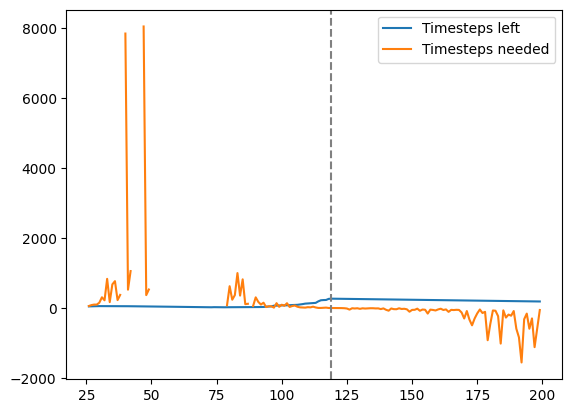

In [132]:
threshold = 0.1
run_id = good_run
timestep_data_df = timestep_data_df_full_with_params[timestep_data_df_full_with_params['run_id'] == run_id]

escrow = timestep_data_df['actors_total_locked_relative']
hours = timestep_data_df['timestep'] * 3
start_hours = hours[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
dynamic_timelock_hours = timestep_data_df['dg_dynamic_timelock_seconds'] / 3600
needed_speed = (threshold - escrow) / (dynamic_timelock_hours - start_hours)
real_speed = escrow.diff() / 3

dynamic_timelock_seconds = timestep_data_df['dg_dynamic_timelock_seconds']

timesteps = timestep_data_df['timestep']
seconds = timesteps * 3 * 60 * 60
start_timestep = timesteps[timestep_data_df['dg_state_name'] == 'VetoSignalling'].min()
start_seconds = start_timestep * 3 * 60 * 60
elapsed_from_start_timesteps = timesteps - start_timestep
elapsed_from_start_seconds = elapsed_from_start_timesteps * 3 * 60 * 60
seconds_left_to_reach_ragequit = dynamic_timelock_seconds - elapsed_from_start_seconds
timesteps_left_to_reach_ragequit = seconds_left_to_reach_ragequit / 3 / 60 / 60
share_left_to_reach_ragequit = threshold - escrow
needed_speed_seconds = share_left_to_reach_ragequit / seconds_left_to_reach_ragequit
needed_speed_timesteps = needed_speed_seconds * 3 * 60 * 60

delta_share = escrow.diff()
delta_timesteps = timesteps.diff()
real_speed_timesteps = delta_share / delta_timesteps

timesteps_needed_to_reach_ragequit = (threshold - escrow) / real_speed_timesteps


timestep_threshold = timesteps[escrow >= threshold].min()


mask = (timesteps > start_timestep) & (timesteps < 200)
plt.plot(timesteps[mask], timesteps_left_to_reach_ragequit[mask], label='Timesteps left')
plt.plot(timesteps[mask], timesteps_needed_to_reach_ragequit[mask], label='Timesteps needed')

ylim = plt.ylim()
plt.plot([timestep_threshold, timestep_threshold], ylim, color='gray', linestyle='--')
plt.ylim(ylim)
plt.legend()

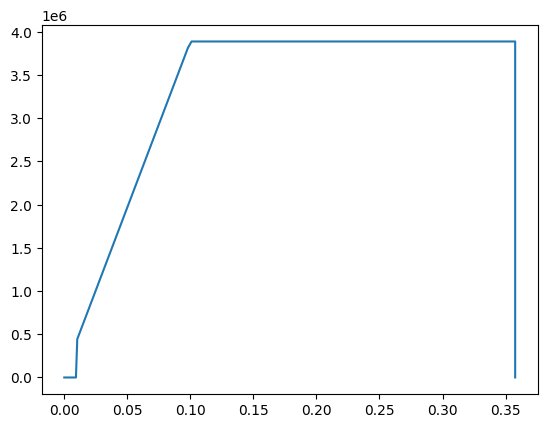

In [133]:
plt.plot(escrow, dynamic_timelock_seconds)

In [134]:
s, e = 50, 100

dynamic_timelock_timesteps = dynamic_timelock_seconds / 3 / 60 / 60

d_s = np.array(dynamic_timelock_timesteps.diff())[e]
d_es = np.array(escrow.diff())[e]
print(d_s, d_es, (d_s / d_es))



3.337685185185194 0.0009387292194230623 3555.5356285133175


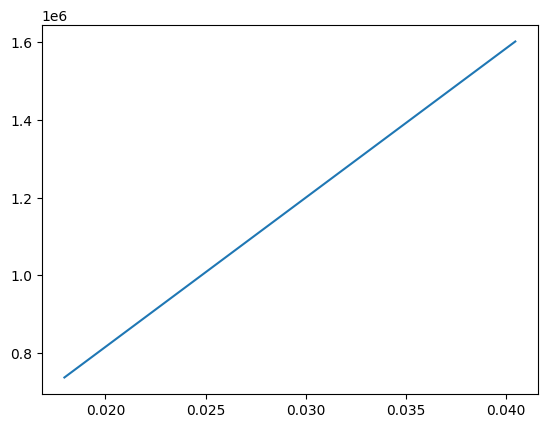

In [147]:
plt.plot(escrow.iloc[50:100], dynamic_timelock_seconds.iloc[50:100])

In [162]:
(dynamic_timelock_timesteps.iloc[100-30] - dynamic_timelock_timesteps.iloc[50]) / (escrow.iloc[100-30] - escrow.iloc[50])








np.float64(3555.398860707864)

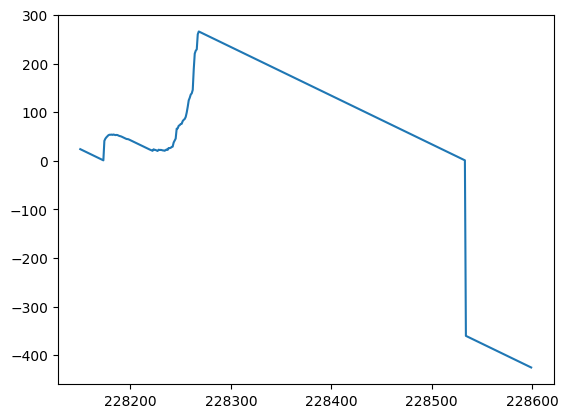

In [164]:
plt.plot(timesteps_left_to_reach_ragequit)